# **AM 207**: Homework 4

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
**Due: 11.59 P.M. Thursday April 7th, 2016**

### Instructions:

+ Upload your answers in an ipython notebook to Canvas.

+ We will provide you imports for your ipython notebook. Please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_YOURNAME_HW4.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ **Do not just send your code. The homework solutions should be in a report style. Be sure to add comments to your code as well as markdown cells where you describe your approach and discuss your results. **

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HW4.tar.gz or AM207_YOURNAME_HW4.zip


### Have Fun!
_ _ _ _ _

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

/Users/charlesliu/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Problem 1: Bayesian Models for Yelp Check-in Data

Below is a visualization of Yelp checkins on a portion of the Las-Vegas strip. The goal of this problem is to model an intensity surface on this map which is indicative of the propensity of an individual to check in at a particular location.
<img src="Rplot.jpeg">
Such an intensity surface is very valuable for example to decide what would be good places to open another casino or restaurant. 

The first hierarchical model will use a conjugate prior (and hence we can compute an analytical solution) and the second will use a non-conjugate set up with correlated priors.

### Data description
We have M grid squares of width $w=0.0005$. The variable `checkins` contains M checkin values, one for each square. The variable `X` contains the coordinates of the center of each square. This data set is a subset of the map shown above.

In [35]:
#load checkins
checkins = np.genfromtxt('checkin_counts.csv', delimiter=',')
#load latitude and longitude values associated with each count value
X = np.genfromtxt('X.csv', delimiter=',')
#set M to the length of the checkins vector
M = checkins.size
#set grid width w to be .0005 latitude/longitude
w = .0005

### Conjugate Model
In the first model, we assume that a map (i.e., the Las Vegas strip) is discretized into $M$ grid squares of width $w$, and the checkins in cell $i$, denoted by $Y_i$, are distributed according to a $Pois(w^2\lambda_i)$ distribution. (That is, the check-ins follow a Poisson process conditioning on the $\lambda$, and $\lambda \in \mathbb{R}^M$ is the intensity surface we would like to infer.) Furthermore $\lambda_i$ is drawn from a conjugate $Gamma(\alpha, \beta)$ distribution. The $Y_i$ are conditionally independent on $\lambda_i$, and $\lambda_i$ is indepndent of $\lambda_j$ for $i \neq j$.

Derive the posterior distribution $p(\lambda_i|Y_i)$ for this model analytically as a function of hyperparameters $\alpha$ and $\beta$. Use the posterior mean as an estimate for $\lambda_i$, and then plot the posterior mean of $\lambda_i$ on a grid for varying values of $\alpha$ and $\beta$. Discuss if this model leads to a useful intensity surface, and how the usefulness of the result is influenced by the choice of $\alpha$ and $\beta$.

### Non-Conjugate Model
Now let's move on to a slightly more complicated model. Again assume that the grid is discretized into $M$ cells of the same area, and the checkins in cell $i$, denoted by $Y_i$, are distributed according to a $Pois(w^2\lambda_i)$ distribution. However there is a twist: we assume $\lambda_i$ is equivalent to $Exp[\alpha+Z_i]$ where $Z \in \mathbb{R}^{M}$ is drawn from a multivariate normal $MVN(0,\Sigma)$ distribution, where $\Sigma$ comes from a squared exponential kernel, and $\alpha$ is drawn according to a N(0,1) distribution. In this way, the $\lambda_i$ for distinct cells are no longer independent but are correlated.(If you'd like to delve deeper, this process is called a "Log-Gaussian Cox process".)

Describe what the meaning of $\alpha$ and $\Sigma$ is for this model. 

We model $\Sigma$ using a square exponential kernel such that the covariances decay exponentially quickly as points get further apart from each other. That is $$\Sigma_{ij} = Exp[-||X_i-X_j||_2^2/\phi]$$

Where $X_i$ and $X_j$ are the $ith$ and $jth$ rows of $X$ respectively. Describe in which way the choice of $\phi$ influences the kernel. By default, use $\phi = .00001$. 

To simplify your code, consider the prior parameters/latent variables ($\alpha$, $Z$) jointly as a vector in $\mathbb{R}^{M+1}$. Determine the covariance matrix for the multivariate normal prior on this vector and store it all together in a variable called Sigma. Give a short explanation why we can do this. 
When you implement the computation of $\Sigma$, small numerical instabilities can lead to a covariance matrix that is not positive-semidefinite. You can check this by attempting a Cholesky decomposition of $\Sigma$ with numpy. If it throws an error, you can add a small offset to the diagonal of the matrix to help with numerical stability. 

We will provide you with code for an elliptical slice sampler for this problem. This sampling method was directly devloped for problems like this and we will discuss it later in class. For now it is sufficient for you to use the code, without neccessarily understanding it. Use the provided sampler to estimate the posterior mean for this non-conjugate model. In addition implement the model also in PYMC or vanilla Metropolis Hastings, and compare the result. 

Finally discuss the differences in results from the conjugate and the non-conjugate model and which one you would prefer. 

### Helper functions

Here is some code that should be useful:

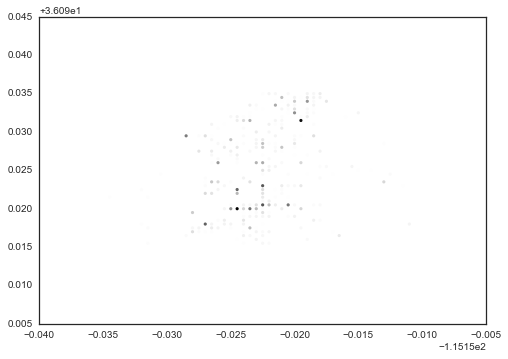

In [204]:
# This function takes a vector of M intensities and plots it according to the coordinates in `X`.
# The values of the intensities are normalized to [0,1] and darker means higher values
def plot_checkins(checkins):
    colors = checkins / np.double(np.max(checkins))
    plt.scatter(X[:,0], X[:,1], s=10, c=colors, cmap='gray_r', edgecolors='none', vmin=0)
    plt.show()
    
plot_checkins(checkins)

### Conjugate prior 
$$
P(\lambda_i | Y_i,\alpha,\beta) = \frac{\beta^\alpha}{\Gamma(\alpha)}\frac{\lambda_i^{Y_i+\alpha-1}e^{-(\beta+1)\lambda_i}}{Y_i!} \approx Gamma(Y_i+\alpha,\beta+1)
$$

In [205]:
# mean of gamma is just alpha/beta
def priormean(alpha, beta):
    return map(lambda x: (x+alpha)/(beta+1),checkins)

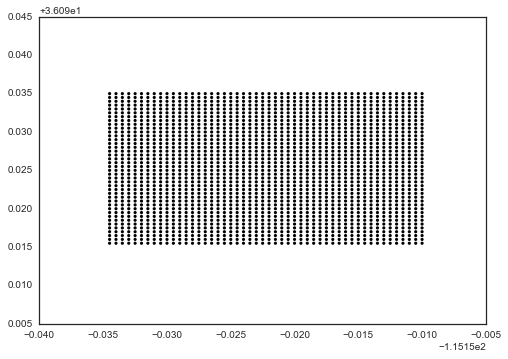

In [209]:
plot_checkins(priormean(10000000, 1))

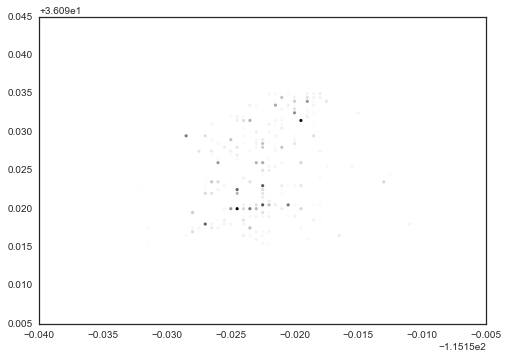

In [210]:
plot_checkins(priormean(1, 10000000))

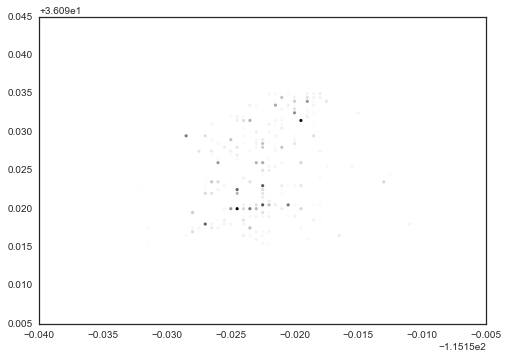

In [211]:
plot_checkins(priormean(1,1))

Skewing alpha over the other will in some sense normalize the intensity of all the places, as all values will reach some extreme and then the plot_checkins normalizes all the values to the max so relatively they will be more similar. This model essentially relies entirely on what you choose for alpha, which isn't very useful

In [49]:
#elliptical slice sampler (Murray, Adams, and MacKay JMLR 2010)
# Inputs:
# Y: observed data
# Sig: covariance matrix of the prior
# log_lik: the log likelihood function
# N_mcmc: number of desired samples
# burn_in: number of burn in iterations
# N: dimensionality of the input, this should be M+1 because alpha is part of Sigma

# returns an array of samples of size N_mcmc x N

    
def ess(Y, Sig,log_lik, N_mcmc, burn_in, N):
    print 'running elliptical slice sampling...'
    mcmc_samples = np.zeros((N_mcmc+burn_in, N))
    norm_samples = np.random.multivariate_normal(np.zeros(N), Sig, N_mcmc+burn_in)
    unif_samples = np.random.uniform(0,1,N_mcmc+burn_in)
    theta = np.random.uniform(0,2*np.pi,N_mcmc+burn_in)
    theta_min = theta-2*np.pi
    theta_max = theta+2*np.pi
    for i in range(1,N_mcmc+burn_in):
        f = mcmc_samples[i-1,:]
        llh_thresh = log_lik(f,Y) + np.log(unif_samples[i])
        f_star = f*np.cos(theta[i])+norm_samples[i,:]*np.sin(theta[i])
        while log_lik(f_star,Y) < llh_thresh:
            if theta[i] < 0:
                theta_min[i] = theta[i]
            else:
                theta_max[i] = theta[i]
            theta[i] = np.random.uniform(theta_min[i],theta_max[i],1)  
            f_star = f*np.cos(theta[i])+norm_samples[i,:]*np.sin(theta[i]) 		
        mcmc_samples[i,:] = f_star
    return mcmc_samples[(burn_in+1):(burn_in+N_mcmc),]

$\alpha$ represents the base checkin rate, $\Sigma$ is specifying the popularity of a region over another. $\phi$ represents level of covariance given some distance between areas, a very low one means low covariance

In [75]:
phi = .00001
#construct the covariance matrix which is constant given locations
#alpha is the first variable in the latent variables, also a normal so can be
#constructed together w/ the squared exponential kernel, just with 0 covariance
#with any other variable
sigma = np.zeros((len(X)+1, len(X)+1))
sigma[0,0] = 1
for i in range(1,len(sigma)):
    for j in range(1,i):
        covar = np.exp(-(np.dot(X[i-1, :] - X[j-1, :],X[i-1, :] - X[j-1, :]))/phi)
        sigma[i,j] = covar
        sigma[j,i] = covar
    sigma[i,i] = 1
sigma

array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   1.00000000e+00,   9.75309912e-01, ...,
          1.16881313e-41,   1.79243298e-42,   2.61472518e-43],
       [  0.00000000e+00,   9.75309912e-01,   1.00000000e+00, ...,
          7.24990824e-41,   1.16881313e-41,   1.79243298e-42],
       ..., 
       [  0.00000000e+00,   1.16881313e-41,   7.24990824e-41, ...,
          1.00000000e+00,   9.75309912e-01,   9.04837418e-01],
       [  0.00000000e+00,   1.79243298e-42,   1.16881313e-41, ...,
          9.75309912e-01,   1.00000000e+00,   9.75309912e-01],
       [  0.00000000e+00,   2.61472518e-43,   1.79243298e-42, ...,
          9.04837418e-01,   9.75309912e-01,   1.00000000e+00]])

In [77]:
# offset to make it invertible
offset = 0.00001
for i in range(len(sigma)):
    sigma[i,i] += offset
np.linalg.cholesky(sigma)

array([[  1.00000500e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   1.00000500e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   9.75305036e-01,   2.20884784e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   1.16880728e-41,   2.76613197e-40, ...,
          5.97911224e-03,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   1.79242402e-42,   4.50007055e-41, ...,
          6.58891723e-03,   6.50269943e-03,   0.00000000e+00],
       [  0.00000000e+00,   2.61471211e-43,   6.96027480e-42, ...,
          6.61284246e-03,   8.35538269e-03,   8.75953047e-03]])

In [97]:
# log-likelihood function
# just summing over the squares poisson logpmf of getting y value given alpha and z
def log_lik(f, Y):
    return np.sum(map(lambda i: scipy.stats.poisson.logpmf(Y[i], w**2*np.exp(f[0]+f[i+1])), xrange(len(Y))))

In [100]:
trace = ess(checkins, sigma, log_lik, 500, 50, M+1)

running elliptical slice sampling...


In [105]:
post_mean = np.mean(trace, 0)
post_lambdas = map(lambda x: w**2*np.exp(post_mean[0]+x), post_mean[1:])

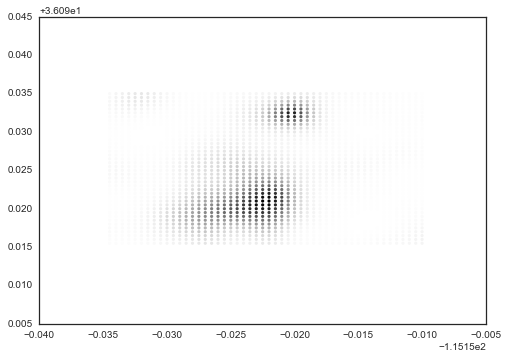

In [212]:
plot_checkins(post_lambdas)

 [-----------------100%-----------------] 10001 of 10000 complete in 1190.0 sec

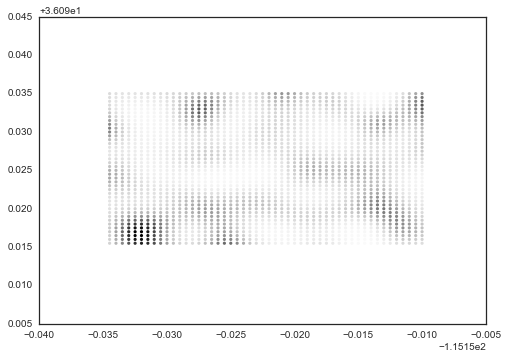

In [213]:
# pymc version
alpha = pm.Normal("alpha", mu = 0, tau = 1)
mvn = pm.MvNormal("mvn", np.zeros(M), np.linalg.inv(sigma[1:, 1:]))
mu = pm.Lambda("mu", lambda alpha=alpha, mvn=mvn: map(lambda x: w**2*np.exp(alpha + x), mvn))
obs = pm.Poisson("obs", mu, value=checkins, observed=True)
mcmc=pm.MCMC([alpha, mvn, mu, obs])
mcmc.sample(iter=10000, burn=1000)
plot_checkins(np.mean(mu.trace(), 0))

Plotting alpha


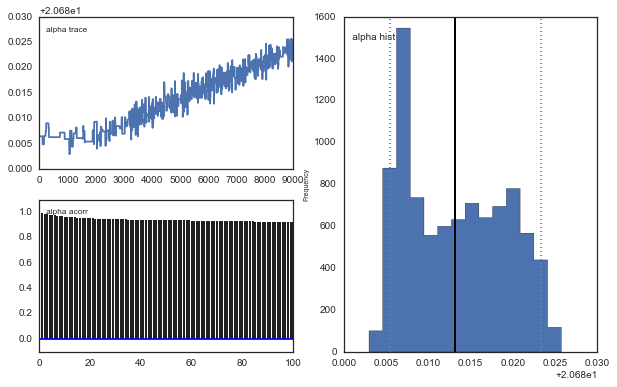

In [214]:
pm.Matplot.plot(alpha)

Not seeing a strong convergence from the pymc implementation even after 10000 iterations. Overall the splice method seemed to perform the best, even though it was quite slow after 500 iterations the plot of the lambdas seemed reasonable. The conjugate model relies too heavily on the hyperparameters

# Problem 2: Point Matching

In this problem you are given two point clouds `points1` and `points2`. Your task is to estimate an affine transformation which can map the points of `points1` onto the points of `points2`. Unfortunately you don't know which points from the two point sets correspond to each other.

We are modeling the correspondences in a correspondence matrix $M$, which is of size $n_1 \times n_2$ where $n_i$ is the number of points in point set $i$. $M_{ij}=1$ indicates that point $x_i$ from `points1` and $y_j$ from `points2` correspond to each other. Each point is only allowed to have one correspondence. So for all $i$ we have $\sum_l^{n_2} M_{il} = 1$ 

The likelihood for this problem is:

$$ \prod_i^{n_1} \prod_j^{n_2} \varphi_{0,\sigma}\left(||Ax_i - y_j||\right)^{M_{ij}} $$

where $\varphi_{0,\sigma}$ is a normal distribution with mean 0 and variance $\sigma^2$. We use $\sigma^2 = 0.01$ as a default for this problem. 

Estimate the affine transform $A$ that matches the two point sets using expectation maximization and simulated annealing and compare the results. What are the strength of each algorithm? Which one would you prefer in which scenario?

Here are some hints that should be useful:
* The M-step of the problem will be a weighted least squares solution. 
* To use linear algebra to solve the M step it is useful to extend the point matrices to contain all possible pairwise correspondence pairs. 
* The weights for the weighted least squares should be updated in your E-step

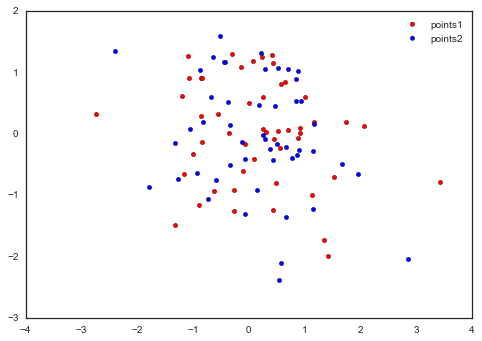

In [140]:
points1 = np.array([[-0.855,  0.905,  1.   ],[ 1.417, -1.999,  1.   ],[-0.896, -1.166,  1.   ],[-0.114, -0.604,  1.   ],
                    [ 2.055,  0.131,  1.   ],[ 0.694,  0.056,  1.   ],[-1.318, -1.495,  1.   ],[ 0.479, -0.799,  1.   ],
                    [-1.081,  0.91 ,  1.   ],[-0.273, -1.258,  1.   ],[ 1.733,  0.188,  1.   ],[ 0.65 ,  0.848,  1.   ],
                    [-0.007,  0.507,  1.   ],[-0.262, -0.922,  1.   ],[-0.14 ,  1.078,  1.   ],[ 0.239,  1.246,  1.   ],
                    [ 0.528,  0.036,  1.   ],[ 0.31 ,  0.025,  1.   ],[-2.734,  0.325,  1.   ],[ 1.014,  0.597,  1.   ],
                    [-0.839, -0.137,  1.   ],[ 0.924,  0.012,  1.   ],[ 0.09 , -0.407,  1.   ],[ 0.433, -1.236,  1.   ],
                    [ 1.345, -1.731,  1.   ],[-0.362,  0.012,  1.   ],[ 0.416,  1.279,  1.   ],[ 1.165,  0.185,  1.   ],
                    [ 0.446, -0.088,  1.   ],[-1.006, -0.335,  1.   ],[ 0.072,  1.188,  1.   ],[ 0.25 ,  0.076,  1.   ],
                    [ 1.525, -0.699,  1.   ],[ 0.574,  0.805,  1.   ],[-1.171, -0.655,  1.   ],[ 0.873, -0.067,  1.   ],
                    [-0.306,  1.291,  1.   ],[-0.07 , -0.174,  1.   ],[-1.088,  1.27 ,  1.   ],[-0.864,  0.295,  1.   ],
                    [-0.845,  0.914,  1.   ],[ 1.136, -1.001,  1.   ],[-0.55 ,  0.328,  1.   ],[-1.201,  0.621,  1.   ],
                    [-0.617, -0.941,  1.   ],[ 0.438,  1.147,  1.   ],[ 0.252,  0.593,  1.   ],[ 3.42 , -0.792,  1.   ],
                    [ 0.923,  0.096,  1.   ],[ 0.563, -0.235,  1.   ]])

points2 = np.array([[-0.131, -0.134,  1.   ],[-2.402,  1.347,  1.   ],[ 0.137, -0.921,  1.   ],[ 0.581, -2.113,  1.   ],
                    [ 0.283,  1.049,  1.   ],[-0.734, -1.058,  1.   ],[ 0.26 , -0.025,  1.   ],[ 0.296, -0.095,  1.   ],
                    [ 0.211,  1.31 ,  1.   ],[ 0.874,  1.023,  1.   ],[-0.336, -0.515,  1.   ],[ 0.859, -0.343,  1.   ],
                    [-0.073, -1.308,  1.   ],[-1.058,  0.075,  1.   ],[ 0.544, -2.389,  1.   ],[-0.827,  0.195,  1.   ],
                    [ 0.666, -1.36 ,  1.   ],[ 0.698,  1.059,  1.   ],[-1.274, -0.734,  1.   ],[-0.52 ,  1.589,  1.   ],
                    [ 1.141, -1.229,  1.   ],[ 0.89 , -0.265,  1.   ],[ 0.521,  1.07 ,  1.   ],[-0.651,  1.254,  1.   ],
                    [-0.686,  0.603,  1.   ],[ 0.502, -0.169,  1.   ],[ 0.925,  0.535,  1.   ],[-0.93 , -0.634,  1.   ],
                    [-0.33 ,  0.149,  1.   ],[-0.431,  1.168,  1.   ],[ 0.43 , -0.433,  1.   ],[ 1.949, -0.665,  1.   ],
                    [-0.872,  1.033,  1.   ],[ 0.378, -0.252,  1.   ],[-1.79 , -0.877,  1.   ],[ 0.781, -0.396,  1.   ],
                    [ 1.147, -0.275,  1.   ],[-0.073, -0.41 ,  1.   ],[ 1.673, -0.489,  1.   ],[-1.332, -0.157,  1.   ],
                    [-0.444,  1.163,  1.   ],[ 0.459,  0.452,  1.   ],[ 0.843,  0.892,  1.   ],[ 0.662, -0.214,  1.   ],
                    [ 0.838,  0.524,  1.   ],[ 0.188,  0.471,  1.   ],[ 1.166,  0.164,  1.   ],[-0.595, -0.751,  1.   ],
                    [-0.382,  0.514,  1.   ],[ 2.857, -2.04 ,  1.   ]])

plt.scatter(points1[:,0], points1[:,1], c='r', label='points1')
plt.scatter(points2[:,0], points2[:,1], c='b', label='points2')
plt.legend()
plt.show()

In [291]:
#simulated annealing solution
#given some correspondence matrix, calculate argmin A, calculate error from A
#randomly change correspondence matrix and recalculate, and so on

# function to change the correspondence matrix
def new_corrmatrix(corr_mat, num_rows):
    change_rows = np.random.randint(0, len(points1), num_rows)
    for row in change_rows:
        # pick a column to change it to
        new_col = np.random.randint(0, len(points2))
        # find the current column it's assigned to
        curr_col = 0
        while corr_mat[row, curr_col] == 0:
            curr_col += 1
        # find the current row that's assigned to new_col
        new_row = 0
        while corr_mat[new_row, new_col] == 0:
            new_row += 1
        #swap the two correspondences
        corr_mat[row, curr_col] = 0
        corr_mat[row, new_col] = 1
        corr_mat[new_row, new_col] = 0
        corr_mat[new_row, curr_col] = 1
    return corr_mat

# function to return corresponding points2 matrix
def get_corr(corr_mat):
    Y = np.zeros(points2.shape)
    for i in range(len(points1)):
        col = 0
        while corr_mat[i, col] == 0:
            col += 1
        Y[i, :] = points2[col, :]
    return Y

# calculate A given correspondence matrix and it's error
def calcA(corr_mat):
    Y = get_corr(corr_mat)    
    A = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(points1),points1)),np.transpose(points1)),Y)
    return (A, np.sum(map(lambda x: np.dot(x, x), np.dot(points1,A)-Y)))

In [343]:
#having temperatures high, want to explore space as much as possible
temperature = 10.0
#start with identity matrix
corr_mat = np.eye(len(points1))
best_found = calcA(corr_mat)
best_corrmat = np.array(corr_mat)
err_trace = [best_found[1]]
prev_E = best_found
m = 10000
ftol = 0.01

for i in xrange(500000):
    # swaps for new corr matrix
    num_swaps = np.max([1,np.floor(np.sqrt(temperature)).astype(int)])
    new_corr_mat = new_corrmatrix(corr_mat, num_swaps)
    new_E = calcA(new_corr_mat)
    deltaE  =  new_E[1] - prev_E[1]
    # update check
    if deltaE < 0 or np.random.rand() < np.exp( -deltaE/temperature):
        if best_found[1] > new_E[1]:
            best_found = new_E
            best_corrmat = np.array(new_corr_mat)
        corr_mat = new_corr_mat
        prev_E = new_E
        err_trace.append(new_E[1])
    
    if len(err_trace) % 100 == 0:
        temperature *= 0.9
        if temperature < 0.01:
            temperature = 10.0
    
    if len(err_trace) > m and np.std(err_trace[-m:])/np.mean(err_trace[-m:]) < ftol:
        break

In [344]:
#resulting A matrix and error
best_found

(array([[ -3.54977348e-01,   6.11478386e-02,   2.77555756e-17],
        [  2.26367302e-01,  -6.52345214e-01,  -5.55111512e-17],
        [  1.89038565e-01,  -5.83376170e-02,   1.00000000e+00]]),
 63.002208976377652)

In [345]:
#print zipped estimated points2 and correspondence of points2
zip(np.round(np.dot(points1, best_found[0]), 3), get_corr(best_corrmat))

[(array([ 0.697, -0.701,  1.   ]), array([ 0.378, -0.252,  1.   ])),
 (array([-0.766,  1.332,  1.   ]), array([-0.431,  1.168,  1.   ])),
 (array([ 0.243,  0.648,  1.   ]), array([ 1.147, -0.275,  1.   ])),
 (array([ 0.093,  0.329,  1.   ]), array([-1.332, -0.157,  1.   ])),
 (array([-0.511, -0.018,  1.   ]), array([ 0.781, -0.396,  1.   ])),
 (array([-0.045, -0.052,  1.   ]), array([ 1.166,  0.164,  1.   ])),
 (array([ 0.318,  0.836,  1.   ]), array([ 0.874,  1.023,  1.   ])),
 (array([-0.162,  0.492,  1.   ]), array([-0.651,  1.254,  1.   ])),
 (array([ 0.779, -0.718,  1.   ]), array([ 0.859, -0.343,  1.   ])),
 (array([ 0.001,  0.746,  1.   ]), array([ 0.43 , -0.433,  1.   ])),
 (array([-0.384, -0.075,  1.   ]), array([ 0.283,  1.049,  1.   ])),
 (array([ 0.15 , -0.572,  1.   ]), array([ 0.544, -2.389,  1.   ])),
 (array([ 0.306, -0.39 ,  1.   ]), array([ 0.843,  0.892,  1.   ])),
 (array([ 0.073,  0.527,  1.   ]), array([ 0.137, -0.921,  1.   ])),
 (array([ 0.483, -0.77 ,  1.   ]),

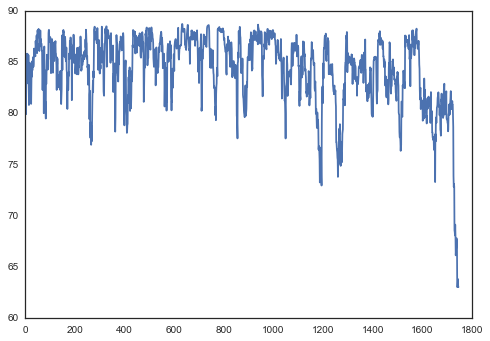

In [346]:
plt.plot(err_trace)

In [418]:
#EM probability matrix for E-step
def P_mat(var, A, t):
    P = np.zeros((len(points1), len(points2)))
    for i in range(len(points1)):
        for j in range(len(points2)):
            diff = np.dot(points1[i,:], A)+t - points2[j,:]
            P[i,j] = np.exp((-1/(2*var)) * np.dot(diff,diff))
    
    # return normalized P
    return P/np.sum(P,0)

# function given P matrix to generate correspondence matrix
# given highest row value
def corr_mat(P):
    maxes = np.max(P, 1)
    corr_mat = np.zeros(P.shape)
    for i in range(len(P)):
        j = 0
        while P[i,j] != maxes[i]:
            j += 1
        corr_mat[i,j] = 1
    return corr_mat

def llh_points(corr_matrix, A, variance):
    #Y is points2 rearranged to match correspondences
    Y = get_corr(corr_matrix)
    #apply transformation to points1
    X = np.dot(points1, A)
    return np.sum(map(lambda x: np.log(scipy.stats.norm.pdf(np.sqrt(np.dot(x,x)), 0, np.sqrt(variance))), X-Y))

In [431]:
#initial values
A = np.eye(3)
t = 0
variance = 0.01
num_points = len(points1)

for i in range(1000):
    P = P_mat(variance, A, t)
    m_x = (np.sum(np.dot(np.transpose(points1), P), 1))/num_points
    m_y = (np.sum(np.dot(np.transpose(points2), np.transpose(P)), 1))/num_points
    new_points1 = points1 - np.array([m_x]*len(points1))
    new_points2 = points2 - np.array([m_y]*len(points2))
    A = np.dot((np.dot(np.dot(np.transpose(new_points2), np.transpose(P)), new_points1)),
              np.linalg.inv(np.diag([.00001]*3) + np.dot(np.dot(np.transpose(new_points1), np.diag(np.sum(P, 1))), new_points1)))
    t = m_y - np.dot(A, m_x)
print(llh_points(corr_mat(P), np.transpose(A), variance))

-3472.81931644


# Problem 3 Time Series

Below you find 200 data points from a time series. Your task is to model this data using a simple autoregressive model:

$$
X_t=\alpha X_{t-1}+r_t
$$
where $r_t$ is normally distributed: $r_t \sim\mathcal{N}(0,\sigma^2)$

Here are your tasks:
* Implement a maximum likelihood estimation(MLE) method to estimate $\alpha$
* Use any MCMC algorithm of your choice to infere $\sigma^2$ and $\alpha$
* Forecast 3 time points ahead and provide posteriors for these three points

In [2]:
# Here is the data
y=np.array([0.00000000e+00,  -2.41884381e-01,  -2.19815584e-01, -5.92654275e-03,   3.89498469e-02,  -7.06374756e-01,
         6.09244734e-02,  -1.36663360e+00,  -1.63887006e+00, -1.31721354e+00,  -1.52424274e+00,  -1.23902096e+00,
        -6.63029664e-01,  -5.97693396e-01,   1.26359198e-01, 6.55116724e-01,   2.98253859e-01,   7.19461104e-03,
         4.04113046e-01,   7.29893878e-01,  -1.96731327e-03, 4.64230686e-01,  -6.79727540e-02,  -4.19137503e-01,
        -4.03256074e-01,  -8.70131096e-01,  -8.25921060e-01, 4.69417714e-01,  -1.00177377e-01,   6.34076840e-02,
        -1.05978178e-01,  -1.48916430e-01,  -5.43573786e-02, 4.61970441e-01,   8.18280558e-01,   2.87185308e-01,
         1.26715777e+00,   6.41828280e-01,   8.77364512e-01, 3.67214345e-01,   6.26413729e-01,   2.87102039e-02,
         4.28449069e-01,   7.31450267e-01,   6.19131504e-01, 6.33373751e-01,   3.17572088e-01,   3.51692600e-01,
        -2.48995087e-02,  -2.53030153e-01,  -2.15503832e-01,-6.20238803e-01,  -5.28176551e-01,  -5.99112522e-01,
         3.32834574e-01,   4.01426008e-01,  -6.37956657e-01,-4.52884655e-01,  -1.16203988e+00,  -8.82257305e-01,
        -6.19309194e-01,  -4.78009274e-01,  -2.32960888e-01, 3.80860392e-01,  -5.52337194e-01,   6.43589528e-01,
        -1.71939822e-01,  -2.22714248e-02,   1.69698173e-01, 2.26875861e-01,   6.27784254e-02,   9.59070565e-01,
        -2.00412521e-01,   1.62853318e-02,  -1.64492388e-02,-5.92514844e-01,  -1.43386816e-01,  -9.50829381e-01,
        -1.07109089e+00,  -5.47941202e-01,  -6.80501959e-01,-1.22073393e+00,  -5.09858830e-01,  -1.24176275e+00,
        -6.30383282e-01,  -8.67182207e-01,  -9.67761290e-01,-1.79674059e-01,   6.09919157e-01,   9.95635469e-02,
         2.28199545e-01,   4.21792446e-01,   1.69467875e-01,-2.59645693e-01,  -4.93207819e-01,  -5.01539736e-01,
        -6.05873935e-01,  -6.11037064e-01,   1.01647103e-01,-1.44991643e-01,  -4.33238432e-02,  -6.41062073e-02,
        -2.85514261e-01,  -3.95586179e-01,  -3.57194799e-01,-2.20170569e-01,  -3.39918202e-01,   1.70035788e-01,
         7.41558107e-01,   8.33120964e-01,   3.73995334e-01, 4.83141624e-01,  -1.28861162e-01,  -4.22192149e-01,
         5.78378631e-01,   1.43550174e-01,  -1.31226657e-01,-5.30885377e-01,  -8.76270272e-01,  -4.34154230e-01,
        -5.02379201e-01,  -5.14585915e-01,  -4.64397849e-01, 1.65475660e-01,   1.07774616e-01,  -9.65587168e-01,
        -8.60566293e-01,  -2.36405434e-01,  -4.12606502e-01,-5.58566210e-01,   1.20028400e+00,   9.96896069e-01,
         4.41653164e-01,   1.59249052e-01,  -1.74168536e-01, 5.63049814e-01,   7.39366310e-01,   6.05361272e-01,
         2.79509214e-01,  -6.26883609e-01,  -4.44982987e-01,-8.69359696e-01,  -9.27422224e-01,  -6.98179880e-01,
        -1.35445853e+00,  -1.12329955e+00,  -4.94572306e-01,-3.40507834e-01,  -8.37907253e-01,  -9.97003760e-01,
        -7.69088724e-01,  -4.77378429e-01,   4.52315984e-02, 8.76114754e-02,  -9.24336169e-02,   4.42178858e-01,
         6.32190755e-01,   8.18383124e-01,   2.95975304e-01,-2.38797237e-02,   1.16395924e-01,   5.62311884e-02,
        -3.15966789e-01,  -3.16808474e-01,  -1.16651970e+00,-1.01729199e+00,  -7.75285712e-01,  -4.17618624e-01,
        -7.65156825e-01,  -5.10469718e-01,  -3.25334859e-01, 1.06358791e-01,   4.03467712e-01,   5.62837155e-01,
         5.87793605e-01,   4.38191557e-01,  -4.17879322e-01,-3.19715350e-01,   3.41624528e-01,   4.93054502e-01,
         3.69746949e-01,   9.62398763e-02,  -2.81485049e-01,-3.37776564e-01,  -1.30858217e-03,   9.83538405e-01,
         6.94986165e-01,   2.41137851e-01,   2.79478944e-01, 5.13500357e-01,   4.17786188e-01,   7.46707509e-01,
         1.25038407e+00,   8.17699739e-01,   8.78811468e-02,-1.20413802e-01,  -1.83227208e-01,   8.06195706e-02,
         4.16043086e-01,   6.45585187e-02])


Log-likelihood formula is: 
$$
logL(\alpha, \sigma^2) = \frac{1-n}{2}log(2\pi\sigma^2) - \frac{1}{2\sigma^2}\sum\limits_{t=2}^{T}(X_t-\alpha X_{t-1})^2
$$
Taking the derivatives and setting to 0, eventually we get the formula:
$$
\frac{(n-1)(\sum\limits_{t=2}^{T}(y_t-ay_{t-1})y_{t-1})}{\sum\limits_{t=2}^T(y_t-ay_{t-1})^2} = 0
$$
$$
a = \frac{\sum\limits_{t=2}^Ty_ty_{t-1}}{\sum\limits_{t=2}^Ty_{t-1}^2}
$$

In [10]:
#MLE
a = np.dot(y[1:],y[:-1])/np.dot(y[:-1],y[:-1])
a

0.68164697755345027

In [14]:
sigma = 0
for i in range(len(y)):
    sigma += (y[i] - a*y[i-1])**2/(len(y)-1)
sigma

0.19044911770003004

In [23]:
#pymc to perform mcmc
def x_logp(value, alpha, x, variance):
    return -np.log(2*np.pi*variance)/2 - (value - alpha*x)**2/(2*variance)
variance = pm.Uniform("variance", lower=0, upper=1)
alpha = pm.Uniform("alpha", lower=0, upper=1)
#independent noise variables for each data point
noise = [pm.Normal(name="noise" + str(i), mu = 0, tau = 1/variance) for i in range(len(y)-1)]
#X0 = 0
value0 = pm.Deterministic(eval=lambda: 0., name="X0", doc="X_0", parents={})
#X values
value = [None]*len(y)
value[0] = value0
for i in range(1,len(y)):
    value[i] = pm.Stochastic(logp=x_logp,doc="X_"+str(i),name="X"+str(i),
                             parents={'alpha':alpha,'x':value[i-1],'variance':variance},value=y[i],observed=True)

In [26]:
mcmc=pm.MCMC([variance,alpha]+noise+value)
mcmc.sample(iter=10000, burn=2500)

 [-----------------100%-----------------] 10000 of 10000 complete in 150.7 sec

0.68298406660342226

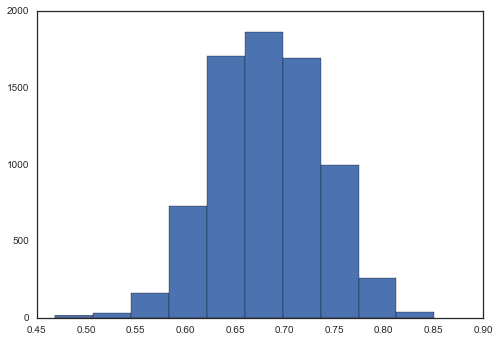

In [29]:
#trace of alpha
plt.hist(mcmc.trace('alpha')[:])
mcmc_alpha = np.mean(mcmc.trace('alpha')[:])
mcmc_alpha

0.19433819910683239

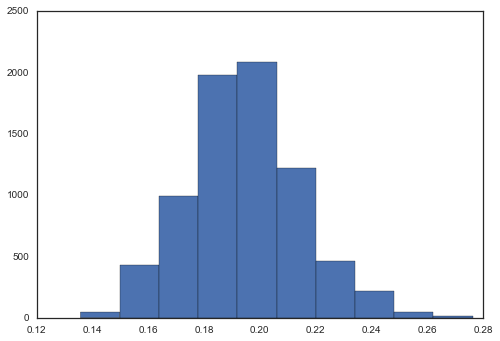

In [30]:
#trace of variance
plt.hist(mcmc.trace('variance')[:])
mcmc_var = np.mean(mcmc.trace('variance')[:])
mcmc_var

In [34]:
# next 3 points with posterior probability
curr_x = y[-1]
for i in range(3):
    new_x = mcmc_alpha*curr_x + np.random.normal(0.0, np.sqrt(mcmc_var))
    print("X_" + str(201+i) + ":" + str(curr_x) + ", posterior probability:" + str(np.exp(x_logp(new_x, mcmc_alpha, curr_x, mcmc_var))))
    curr_x = new_x

X_201:0.0645585187, posterior probability:0.464106635774
X_202:-0.465368406384, posterior probability:0.869108419611
X_203:-0.192488336999, posterior probability:0.891357521041


# Extra Problem 4: Final Project Proposal 

Think about your final project proposal. Your final project is your chance to show off what you learned in AM207! You have seen a lot of different models and examples in lecture and in the homework assignments. In your final project you are free to apply all the techniques you learned to an area of your choice. Be careful not to choose data that you still need to label yourself or that will take you ages to clean. The main focus should be on finding a good model and comparing different techniques for sampling, optimization, etc. 

Please note that there will be a google spreadsheet where you can submit your final project proposal abstract. No need to write it into this notebook. 

The abstract should be short, but contain a short description of your final project idea, which methods you are planning on using, and where your data will come from. 